# Úkol č. 1 - redukce dimenzionality a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz/BI-ML2/homeworks/index.html](https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzazším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>

  * Použijte natrénovaný generativní model Naivního Bayesova klasifikátoru nebo Lineární diskriminační analýzy (podle Vaší volby) a vygenerujte pro každou třídu 5 datových bodů, které následně přetransformujte do rozměrů 28x28 a zobrazte pomocí `imshow`. Diskutujte kvalitu vygenerovaných dat. K vygenerování můžete využít funkci [multivariate_normal](https://numpy.org/doc/2.2/reference/random/generated/numpy.random.multivariate_normal.html) z `numpy`.

  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky aplikace modelů (žádné další generování už nedělejte) a pokuste se je vylepšit.
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
       * Ukázka, jak by mělo vypadat prvních několik řádků souboru `results.csv` (obecně s jinými hodnotami):
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [4]:
### odtud už je to Vaše

import pandas as pd
import numpy as np
import scipy as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import Binarizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.base import clone

random_seed = 333

# Analyzing dataset and preprocessing data

In [5]:
df_data = pd.read_csv("train.csv")
df_data.info()
df_data.dtypes
df_data.describe()
df_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 9.0 MB


(1500, 785)

Check how many missing values in dataset 

In [6]:
df_data.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

Check how many duplicate values in dataset

In [7]:
 print(df_data.duplicated().sum())

0


**Displaying the first 15 images**

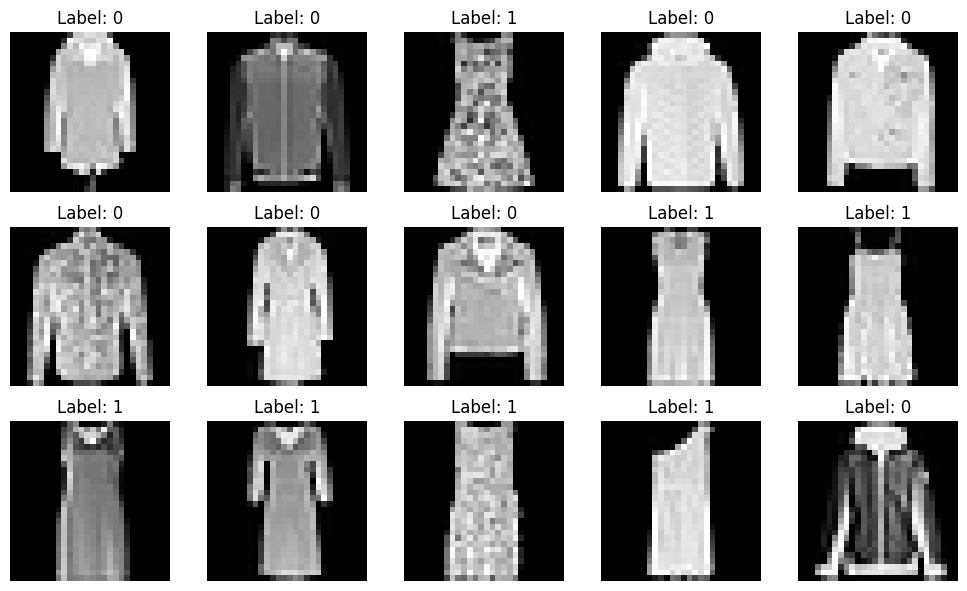

In [8]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    img = df_data.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {df_data.iloc[i, 0]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

I will calculate the average image for each class to observe typical visual patterns

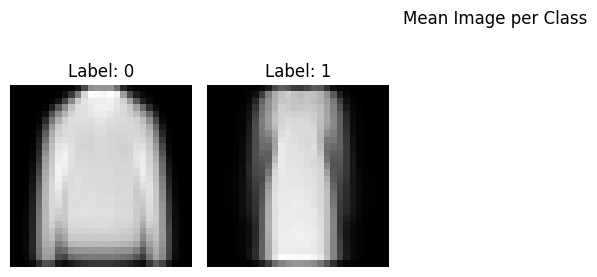

In [9]:
plt.figure(figsize=(10, 6))
for label in sorted(df_data['label'].unique()):
    mean_img = df_data[df_data['label'] == label].iloc[:, 1:].mean(axis=0).values.reshape(28, 28)
    plt.subplot(2, 5, label + 1)
    plt.imshow(mean_img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.suptitle("Mean Image per Class")
plt.tight_layout()
plt.show()


Class 0 looks wider, class 1 more vertical. The classes seem visually distinct

I will visualize how samples are distributed across classes.

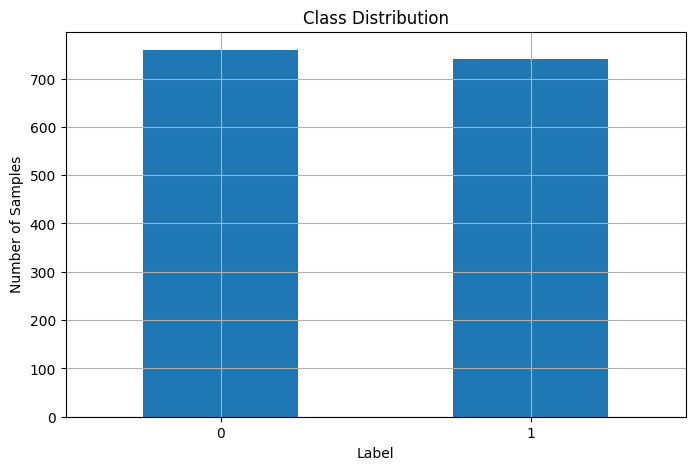

In [10]:
label_counts = df_data['label'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

Classes are well balanced, which is good for training classifiers.

I have checked the dataset for possible missing values and duplicates, so now i can split dataset into Training, Test and Evaluation data

We split the dataset into training (60%), validation (20%), and test (20%) sets. Stratified sampling ensures equal class distribution.

In [11]:
X = df_data.iloc[:, 1:].values
y = df_data['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=random_seed)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_seed)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Train set: (900, 784)
Validation set: (300, 784)
Test set: (300, 784)


# Data preprocessing and analysis are complete. Now I will train and evaluate models.

# Support Vector Machines(SVM)

**SVM(Linear kernel)**

In [10]:
svm_linear = SVC(kernel='linear', C=1.0, random_state=random_seed)
svm_linear.fit(X_train, y_train)

y_train_pred_lin = svm_linear.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred_lin)
print(f"Training Accuracy (Linear SVM): {train_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_lin))

Training Accuracy (Linear SVM): 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       455
           1       1.00      1.00      1.00       445

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



The model performs well on the training set. I will validate it on unseen data later.

SVM(RBF kernel)

In [11]:
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=random_seed)
svm_rbf.fit(X_train, y_train)

y_train_pred_rbf = svm_rbf.predict(X_train)

train_accuracy_rbf = accuracy_score(y_train, y_train_pred_rbf)
print(f"Training Accuracy (RBF SVM): {train_accuracy_rbf:.4f}")
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_rbf))

Training Accuracy (RBF SVM): 0.9700

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       455
           1       0.97      0.97      0.97       445

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



SVM(polynomial kernel)

In [12]:
svm_poly = SVC(kernel='poly', C=1.0, gamma='scale', random_state=random_seed)
svm_poly.fit(X_train, y_train)

y_train_pred_poly = svm_poly.predict(X_train)

train_accuracy_poly = accuracy_score(y_train, y_train_pred_poly)
print(f"Training Accuracy (SVM poly kernel): {train_accuracy_poly:.4f}")
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_poly))

Training Accuracy (SVM poly kernel): 0.9544

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       455
           1       0.92      0.99      0.96       445

    accuracy                           0.95       900
   macro avg       0.96      0.95      0.95       900
weighted avg       0.96      0.95      0.95       900



**I now evaluate trained models on the validation set to compare their generalization performance.**

In [13]:
y_val_pred_lin = svm_linear.predict(X_val)
y_val_pred_rbf = svm_rbf.predict(X_val)
y_val_pred_poly = svm_poly.predict(X_val)

val_acc_linear = accuracy_score(y_val, y_val_pred_lin)
val_acc_rbf = accuracy_score(y_val, y_val_pred_rbf)
val_acc_poly = accuracy_score(y_val, y_val_pred_poly)

print(f"Validation Accuracy (Linear SVM): {val_acc_linear:.4f}")
print(f"Validation Accuracy (RBF SVM):    {val_acc_rbf:.4f}")
print(f"Validation Accuracy (Polynomial SVM): {val_acc_poly:.4f}")

Validation Accuracy (Linear SVM): 0.9567
Validation Accuracy (RBF SVM):    0.9667
Validation Accuracy (Polynomial SVM): 0.9400


**Combined Grid Search: Scalers, Kernels, and Hyperparameters**

We evaluate multiple SVM models by combining different preprocessing scalers (Standard, MinMax, Robust, or none) with various SVM kernel types (linear, rbf, poly). For each combination, we also tune `C`, `gamma`, and `degree` (for polynomial kernels only). All models are trained and evaluated on the validation set, and results are stored for further comparison and visualization.


In [139]:
scaler_options = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'none': None  
}

param_grid = {
    'scaler': ['standard', 'minmax', 'robust', 'none'],
    'kernel': ['linear', 'rbf', 'poly'],
    'C': np.arange(0.1, 5, 0.1),
    'gamma': ['scale', 0.001, 0.01, 0.1, 1.0],
    'degree': range(2, 6)  
}

param_comb = list(ParameterGrid(param_grid))

results_svm = []

for params in param_comb:
    kernel = params['kernel']
    scaler_type = params['scaler']
    degree = params.get('degree', 3)
    
    if kernel != 'poly':
        degree = None

    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()

    scaler = scaler_options[scaler_type]
    if scaler:
        scaler.fit(X_train_copy)
        X_train_copy = scaler.transform(X_train_copy)
        X_val_copy = scaler.transform(X_val_copy)

    clf = SVC(
        kernel=kernel,
        C=params['C'],
        gamma=params['gamma'],
        degree=degree if degree else 3,  
        random_state=random_seed
    )

    clf.fit(X_train_copy, y_train)
    acc = accuracy_score(y_val, clf.predict(X_val_copy))

    result = {
        'scaler': scaler_type,
        'kernel': kernel,
        'C': params['C'],
        'gamma': params['gamma'],
        'degree': degree,
        'accuracy': acc
    }
    results_svm.append(result)

# len(results_svm)

Plot evaluating results

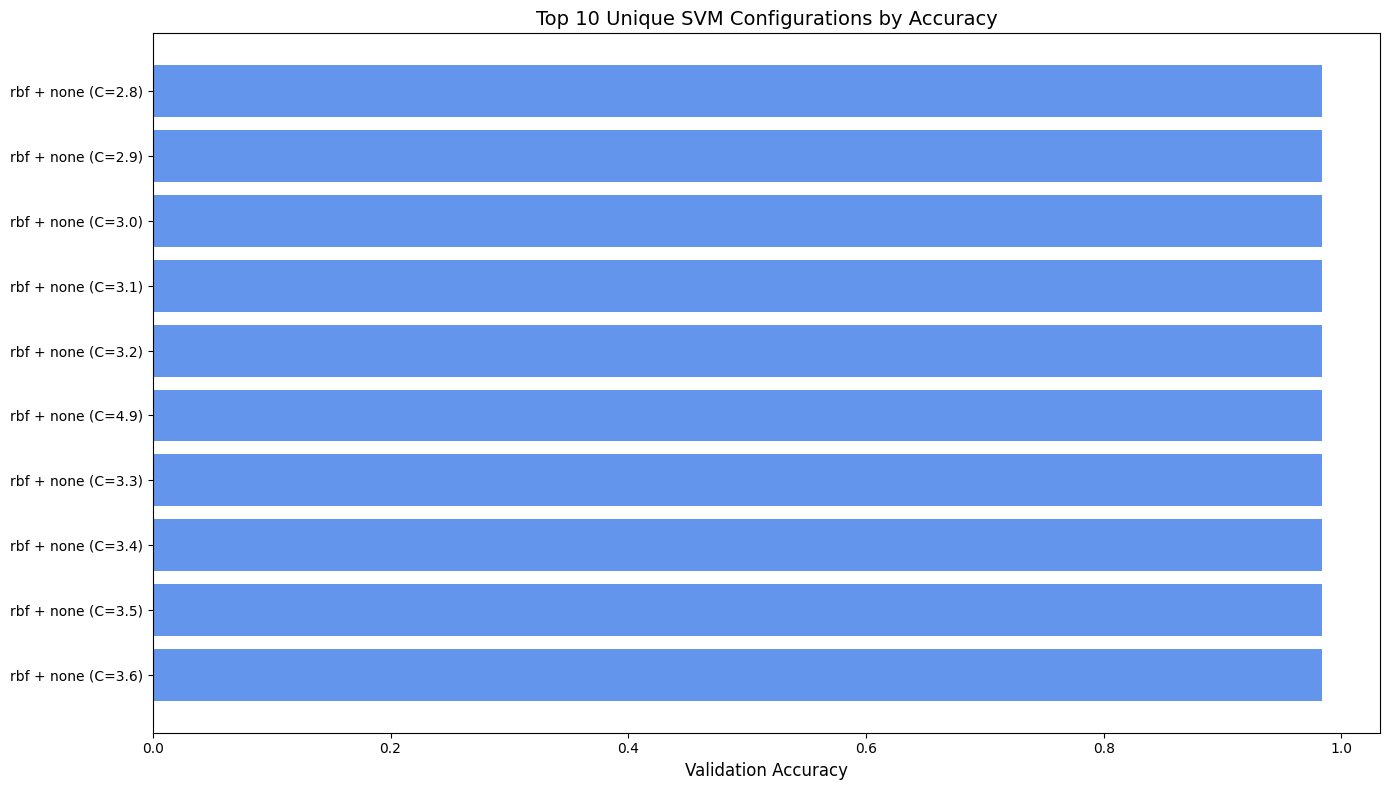

Best SVM Configuration:
Kernel: rbf
Scaler: none
C: 2.8
Gamma: scale
Degree: nan
Validation Accuracy: 0.9833


In [175]:
df_results_svm = pd.DataFrame(results_svm)
df_results_svm['C'] = df_results_svm['C'].round(2)

df_results_svm['label'] = df_results_svm['kernel'] + ' + ' + df_results_svm['scaler'] + ' (C=' + df_results_svm['C'].astype(str) + ')'

top_svm_df = df_results_svm.sort_values(by='accuracy', ascending=False)
top_svm_df['accuracy'] = top_svm_df['accuracy'].round(4)
top_svm_df = top_svm_df.drop_duplicates(subset='label').head(10).copy()

plt.figure(figsize=(14, 8))
bars = plt.barh(top_svm_df['label'], top_svm_df['accuracy'], color='cornflowerblue')
plt.xlabel('Validation Accuracy', fontsize=12)
plt.title('Top 10 Unique SVM Configurations by Accuracy', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

best_config = top_svm_df.iloc[0]
print("Best SVM Configuration:")
print(f"Kernel: {best_config['kernel']}")
print(f"Scaler: {best_config['scaler']}")
print(f"C: {best_config['C']}")
print(f"Gamma: {best_config['gamma']}")
print(f"Degree: {best_config['degree']}")
print(f"Validation Accuracy: {best_config['accuracy']:.4f}")

All top SVM configurations use the RBF kernel without scaling, likely because:

The RBF kernel effectively adapts to the dataset’s raw feature scales, negating the need for normalization.

Proper tuning of hyperparameters (C and gamma) compensates for unscaled data.

# Naive Bayes Classifier

In this section, we evaluate multiple Naive Bayes classifiers (GaussianNB, MultinomialNB, BernoulliNB)
across different preprocessing strategies (no scaling, standardization, normalization, robust scaling, binarization).
For each model, we perform a grid search over its hyperparameters.
The code trains the models on the training data, evaluates them on the validation set,
stores the results, and visualizes the top configurations by validation accuracy.

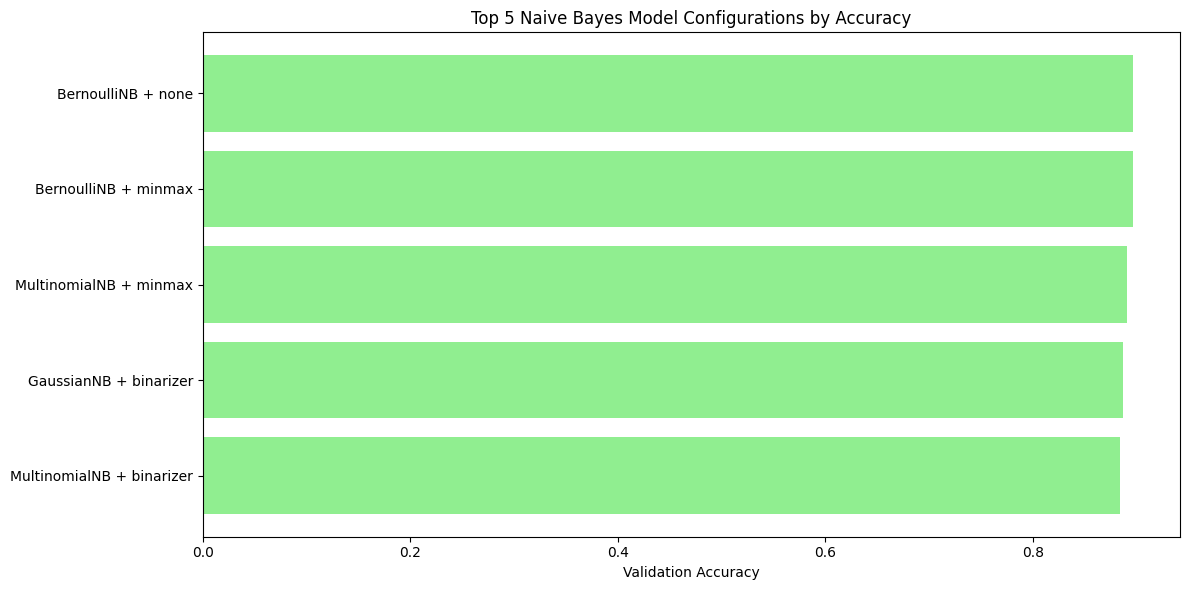

Best Naive Bayes model configuration:
Model: BernoulliNB
Scaler: none
Parameters: {'alpha': np.float64(0.01), 'binarize': np.float64(2.01)}
Validation Accuracy: 0.8967


In [141]:
# Scalers
scalers = {
    'none': None,
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'binarizer': Binarizer()
}

# Parameter grids
models_grid = {
    'GaussianNB': {
        'model': GaussianNB,
        'params': {
            'var_smoothing': np.arange(0.0001, 10, 0.01)
        }
    },
    'MultinomialNB': {
        'model': MultinomialNB,
        'params': {
            'alpha': np.arange(0.0001, 10, 0.01)
        }
    },
    'BernoulliNB': {
        'model': BernoulliNB,
        'params': {
            'alpha': np.arange(0.01, 3, 0.5),
            'binarize': np.arange(0.01, 3, 0.1)
        }
    }
}

results_nb = []
for model_name, info in models_grid.items():
    for scaler_name, scaler in scalers.items():
        if model_name == 'MultinomialNB' and scaler_name in ['standard', 'robust']:
            continue
        if model_name == 'BernoulliNB' and scaler_name in ['standard', 'robust']:
            continue
        
        for params in ParameterGrid(info['params']):
            X_train_copy = X_train.copy()
            X_val_copy = X_val.copy()

            if scaler:
                scaler.fit(X_train_copy)
                X_train_copy = scaler.transform(X_train_copy)
                X_val_copy = scaler.transform(X_val_copy)

            clf = info['model'](**params)
            clf.fit(X_train_copy, y_train)
            acc = accuracy_score(y_val, clf.predict(X_val_copy))

            results_nb.append({
                'model': model_name,
                'scaler': scaler_name,
                'params': params,
                'accuracy': acc
            })

# Convert results to DataFrame for bar plot
nb_df = pd.DataFrame(results_nb)
nb_df['label'] = nb_df['model'] + ' + ' + nb_df['scaler']

# Sort by accuracy and plot
nb_df_sorted = nb_df.sort_values(by='accuracy', ascending=False)\
                    .drop_duplicates(subset='label')\
                    .head(5)

plt.figure(figsize=(12, 6))
plt.barh(nb_df_sorted['label'], nb_df_sorted['accuracy'], color='lightgreen')
plt.xlabel('Validation Accuracy')
plt.title('Top 5 Naive Bayes Model Configurations by Accuracy')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

best_model_nb = nb_df.loc[nb_df['accuracy'].idxmax()]
print("Best Naive Bayes model configuration:")
print(f"Model: {best_model_nb['model']}")
print(f"Scaler: {best_model_nb['scaler']}")
print(f"Parameters: {best_model_nb['params']}")
print(f"Validation Accuracy: {best_model_nb['accuracy']:.4f}")

The bar chart displays the **top 5 Naive Bayes model** configurations based on their validation accuracy. Each configuration is a combination of a Naive Bayes variant (GaussianNB, MultinomialNB, or BernoulliNB) and a preprocessing method (none, minmax, or binarizer).

From the chart, we can observe that:

**BernoulliNB** without any scaling achieves the highest validation accuracy, suggesting that this model handles the raw feature distribution well.

MinMax scaling slightly improves or maintains the performance for both BernoulliNB and MultinomialNB.

**MultinomialNB** appears in the top configurations, indicating it is a **strong baseline when features are properly scaled**.

Interestingly, even GaussianNB with binarized input made it to the top 5, though typically it's used with continuous features.

This comparison shows the importance of both model choice and feature preprocessing. Different combinations can lead to subtle but significant improvements in model performance.



Generating 5 images per class using GaussianNB

# Linear Discriminant Analysis(LDA)

Training LDA and check result accuracy without any data scaling

In [45]:
lda_1d = LinearDiscriminantAnalysis(n_components=1)
X_train_lda_1d = lda_1d.fit_transform(X_train, y_train)

y_val_pred = lda_1d.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)

print(f"LDA Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred))

final_model_for_generation = lda_1d

LDA Validation Accuracy: 0.8100

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       152
           1       0.78      0.86      0.82       148

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



We can see that w/o any scaling we got much worse accuracy in compare with SVM or NB models.

Visualization of 1D projection(1 component)

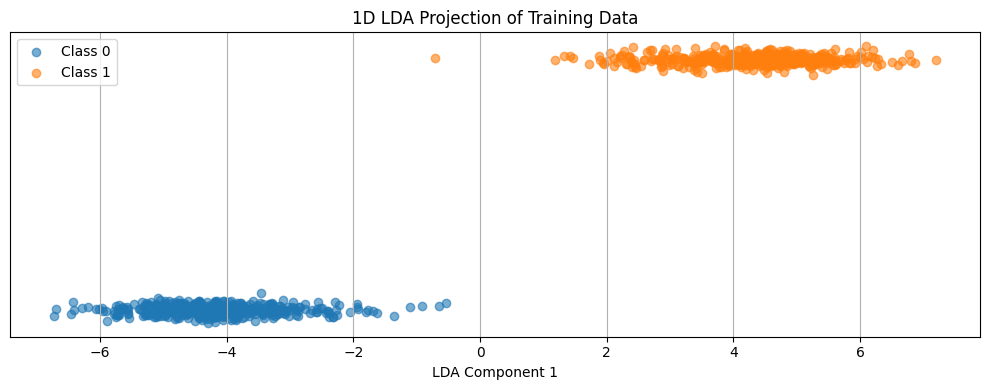

In [143]:
plt.figure(figsize=(10, 4))

for label in np.unique(y_train):
    x = X_train_lda_1d[y_train == label, 0]
    y = np.random.normal(loc=label, scale=0.02, size=len(x))  # spread vertically for better visibility
    plt.scatter(x, y, label=f'Class {label}', alpha=0.6)

plt.title("1D LDA Projection of Training Data")
plt.xlabel("LDA Component 1")
plt.yticks([])  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This 1D LDA projection shows that the two classes are well-separated along a single discriminant axis. Class 0 and Class 1 form distinct clusters, suggesting that LDA effectively reduces dimensionality while preserving class separability.

Model training using different scaling(Robust, MinMax, Standart)

In [144]:
scaler_minmax = MinMaxScaler().fit(X_train)
X_train_minmax = scaler_minmax.transform(X_train)
X_val_minmax = scaler_minmax.transform(X_val)

clflda_minmax = LinearDiscriminantAnalysis()
clflda_minmax.fit(X_train_minmax, y_train)
accuracy_minmax = accuracy_score(y_val, clflda_minmax.predict(X_val_minmax))
print(f"Accuracy LDA with MinMaxScaler: {accuracy_minmax:.4f}")

# StandardScaler
scaler_standard = StandardScaler().fit(X_train)
X_train_standard = scaler_standard.transform(X_train)
X_val_standard = scaler_standard.transform(X_val)

clflda_standard = LinearDiscriminantAnalysis()
clflda_standard.fit(X_train_standard, y_train)
accuracy_standard = accuracy_score(y_val, clflda_standard.predict(X_val_standard))
print(f"Accuracy LDA with StandardScaler: {accuracy_standard:.4f}")


scaler_robust = RobustScaler().fit(X_train)
X_train_robust = scaler_robust.transform(X_train)
X_val_robust = scaler_robust.transform(X_val)

clflda_robust = LinearDiscriminantAnalysis()
clflda_robust.fit(X_train_robust, y_train)
accuracy_robust = accuracy_score(y_val, clflda_robust.predict(X_val_robust))
print(f"Accuracy LDA with RobustScaler: {accuracy_robust:.4f}")

Accuracy LDA with MinMaxScaler: 0.8100
Accuracy LDA with StandardScaler: 0.8100
Accuracy LDA with RobustScaler: 0.8100


Parameter grid for LDA

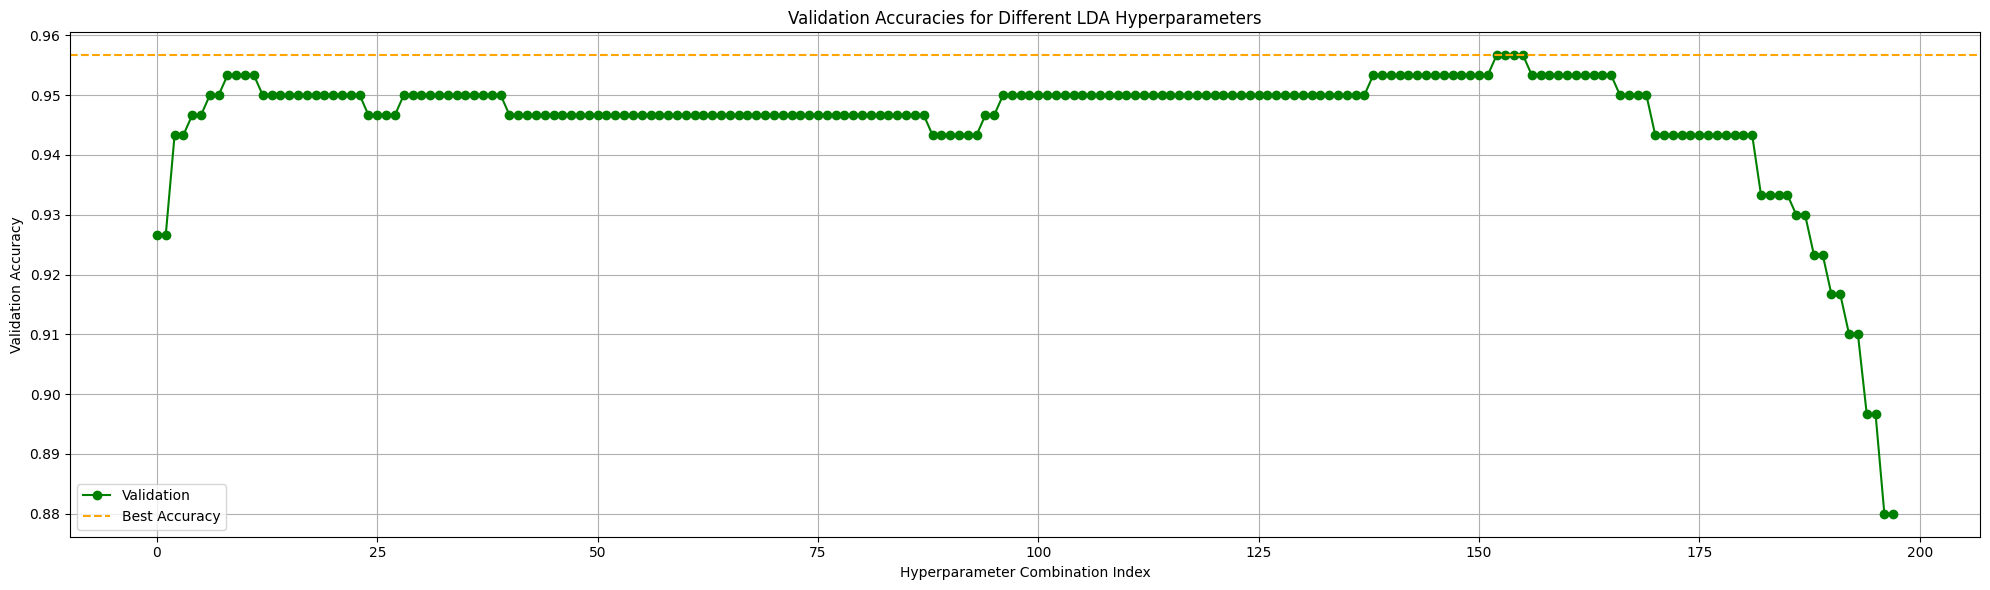

Best LDA hyperparameter configuration:
Solver: lsqr
Shrinkage: 0.77
n_components: 1
Validation Accuracy: 0.9567


In [12]:
param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': np.arange(0.01, 1, 0.01),
    'n_components': range(1, min(len(np.unique(y_train)), X_train.shape[1]))
}

param_comb = list(ParameterGrid(param_grid))

val_metric = []
for params in param_comb:
    clf_lda = LinearDiscriminantAnalysis(**params)
    clf_lda.fit(X_train, y_train)
    acc = accuracy_score(y_val, clf_lda.predict(X_val))
    val_metric.append(acc)

best_idx = np.argmax(val_metric)
best_params_clflda = param_comb[best_idx]
best_accuracy_clflda = val_metric[best_idx]

plt.figure(figsize=(20,6))
plt.plot(val_metric, 'go-', label='Validation')
plt.axhline(y=best_accuracy_clflda, color='orange', linestyle='--', label='Best Accuracy')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracies for Different LDA Hyperparameters')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Best LDA hyperparameter configuration:")
print(f"Solver: {best_params_clflda['solver']}")
print(f"Shrinkage: {best_params_clflda['shrinkage']}")
print(f"n_components: {best_params_clflda['n_components']}")
print(f"Validation Accuracy: {best_accuracy_clflda:.4f}")

**Combining LDA and different SVM kernels**

In [179]:
scalers = {
    'none': None,
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler()
}

print("LDA + SVM (RBF Kernel)\n")
results_rbf_lda = []

for scaler_name, scaler in scalers.items():
    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()

    if scaler:
        scaler.fit(X_train_copy)
        X_train_copy = scaler.transform(X_train_copy)
        X_val_copy = scaler.transform(X_val_copy)

    lda = LinearDiscriminantAnalysis()
    X_train_lda = lda.fit_transform(X_train_copy, y_train)
    X_val_lda = lda.transform(X_val_copy)

    clf = SVC(kernel='rbf', C=1, gamma='scale', random_state=random_seed)
    clf.fit(X_train_lda, y_train)
    acc = accuracy_score(y_val, clf.predict(X_val_lda))

    results_rbf_lda.append((scaler_name, acc))

for name, acc in results_rbf_lda:
    print(f"Accuracy (RBF) with {name}: {acc:.4f}")

LDA + SVM (RBF Kernel)

Accuracy (RBF) with none: 0.7900
Accuracy (RBF) with standard: 0.7900
Accuracy (RBF) with minmax: 0.7900
Accuracy (RBF) with robust: 0.7900


In [147]:
# Adding Binarizer into scalers
scalers_lin_poly = {
    'none': None,
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'binarizer': Binarizer()
}

print("\nLDA + SVM (Linear Kernel)\n")
results_lin_lda = []

for scaler_name, scaler in scalers_lin_poly.items():
    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()

    if scaler:
        scaler.fit(X_train_copy)
        X_train_copy = scaler.transform(X_train_copy)
        X_val_copy = scaler.transform(X_val_copy)

    # Apply LDA transformation
    lda = LinearDiscriminantAnalysis()
    X_train_lda = lda.fit_transform(X_train_copy, y_train)
    X_val_lda = lda.transform(X_val_copy)

    clf = SVC(kernel='linear', C=1, random_state=random_seed)
    clf.fit(X_train_lda, y_train)
    acc = accuracy_score(y_val, clf.predict(X_val_lda))

    results_lin_lda.append((scaler_name, acc))

for name, acc in results_lin_lda:
    print(f"Accuracy (Linear) with {name}: {acc:.4f}")



LDA + SVM (Linear Kernel)

Accuracy (Linear) with none: 0.8067
Accuracy (Linear) with standard: 0.8067
Accuracy (Linear) with minmax: 0.8067
Accuracy (Linear) with robust: 0.8067
Accuracy (Linear) with binarizer: 0.8367


In [148]:
print("\nLDA + SVM (Poly Kernel)\n")
results_poly_lda = []

for scaler_name, scaler in scalers_lin_poly.items():
    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()

    if scaler:
        scaler.fit(X_train_copy)
        X_train_copy = scaler.transform(X_train_copy)
        X_val_copy = scaler.transform(X_val_copy)

    # Apply LDA transformation
    lda = LinearDiscriminantAnalysis()
    X_train_lda = lda.fit_transform(X_train_copy, y_train)
    X_val_lda = lda.transform(X_val_copy)

    clf = SVC(kernel='poly', C=1, degree=3, gamma='scale', random_state=random_seed)
    clf.fit(X_train_lda, y_train)
    acc = accuracy_score(y_val, clf.predict(X_val_lda))

    results_poly_lda.append((scaler_name, acc))

for name, acc in results_poly_lda:
    print(f"Accuracy (Poly) with {name}: {acc:.4f}")


LDA + SVM (Poly Kernel)

Accuracy (Poly) with none: 0.8033
Accuracy (Poly) with standard: 0.8033
Accuracy (Poly) with minmax: 0.8033
Accuracy (Poly) with robust: 0.8033
Accuracy (Poly) with binarizer: 0.8233


**Short conclusion:**

LDA reduces the data to one dimension, and when combined with SVM:

Linear and Poly kernels: Achieve around 80% accuracy with standard, minmax, or robust scaling, but using a binarizer boosts accuracy to approximately 83.7% (linear) and 82.3% (poly).

RBF kernel: Remains around 79% accuracy regardless of scaling.

Thus, for LDA+SVM, using a binarizer with linear or polynomial kernels is recommended for better performance.

**Combining LDA and different NB variations**

In [149]:
scalers = {
    'none': None,
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler()
}

results_gaussian_lda = []

for scaler_name, scaler in scalers.items():
    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()

    if scaler:
        scaler.fit(X_train_copy)
        X_train_copy = scaler.transform(X_train_copy)
        X_val_copy = scaler.transform(X_val_copy)

    lda = LinearDiscriminantAnalysis()
    X_train_lda = lda.fit_transform(X_train_copy, y_train)
    X_val_lda = lda.transform(X_val_copy)

    model = GaussianNB()
    model.fit(X_train_lda, y_train)
    y_pred = model.predict(X_val_lda)
    acc = accuracy_score(y_val, y_pred)

    results_gaussian_lda.append({'model': 'GaussianNB', 'scaler': scaler_name, 'accuracy': acc})

# DataFrame
df_gaussian = pd.DataFrame(results_gaussian_lda).sort_values(by='accuracy', ascending=False)
print("GaussianNB + LDA results:")
print(df_gaussian)

GaussianNB + LDA results:
        model    scaler  accuracy
0  GaussianNB      none  0.806667
1  GaussianNB  standard  0.806667
2  GaussianNB    minmax  0.806667
3  GaussianNB    robust  0.806667


In [150]:
scalers_bernoulli = {
    'none': None,
    'minmax': MinMaxScaler()
}

results_bernoulli = []

for scaler_name, scaler in scalers_bernoulli.items():
    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()

    if scaler:
        scaler.fit(X_train_copy)
        X_train_copy = scaler.transform(X_train_copy)
        X_val_copy = scaler.transform(X_val_copy)

    lda = LinearDiscriminantAnalysis()
    X_train_lda = lda.fit_transform(X_train_copy, y_train)
    X_val_lda = lda.transform(X_val_copy)

    model = BernoulliNB()
    model.fit(X_train_lda, y_train)
    y_pred = model.predict(X_val_lda)
    acc = accuracy_score(y_val, y_pred)

    results_bernoulli.append({'model': 'BernoulliNB', 'scaler': scaler_name, 'accuracy': acc})

df_bernoulli = pd.DataFrame(results_bernoulli).sort_values(by='accuracy', ascending=False)
print("BernoulliNB + LDA results:")
print(df_bernoulli)

BernoulliNB + LDA results:
         model  scaler  accuracy
0  BernoulliNB    none  0.806667
1  BernoulliNB  minmax  0.806667


**Short conclusion:**

Both GaussianNB and BernoulliNB, when combined with LDA, achieve similar validation accuracies of about 80.67%. This indicates that even though LDA transforms the data into continuous components, BernoulliNB can perform comparably to GaussianNB when the binarization threshold is appropriately tuned and no additional shifting is applied

Generating 5 images per class using LDA

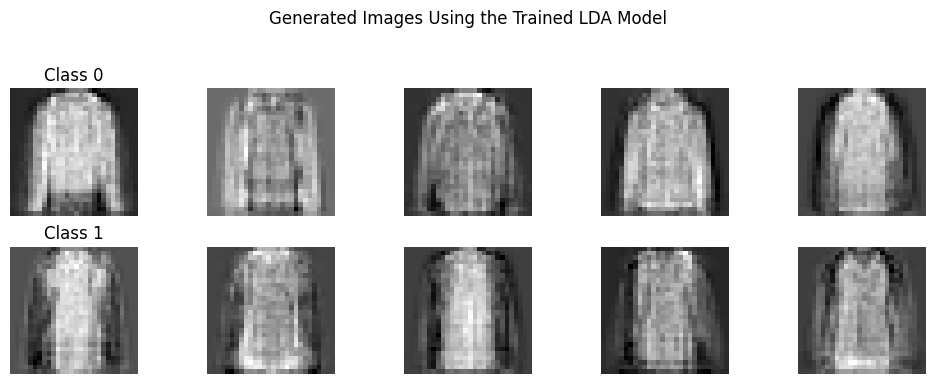

In [47]:
samples_per_class = 5
generated_samples = {}

if hasattr(final_model_for_generation, "covariance_"):
    cov = final_model_for_generation.covariance_
else:
    pooled_cov = np.zeros((n_features, n_features))
    for cl in unique_classes:
        X_class = X_train[y_train == cl]
        cov_class = np.cov(X_class, rowvar=False)
        pooled_cov += cov_class * (X_class.shape[0] - 1)
    pooled_cov /= (n_samples - len(unique_classes))
    pooled_cov += np.eye(n_features) * 1e-6
    cov = pooled_cov

for idx, cl in enumerate(final_model_for_generation.classes_):
    mu = final_model_for_generation.means_[idx]
    samples = np.random.multivariate_normal(mu, cov, samples_per_class)
    generated_samples[cl] = samples

n_classes = len(final_model_for_generation.classes_)
fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(samples_per_class*2, n_classes*2))
for i, cl in enumerate(final_model_for_generation.classes_):
    for j in range(samples_per_class):
        ax = axes[i, j] if n_classes > 1 else axes[j]
        img = generated_samples[cl][j].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_title(f"Class {cl}", fontsize=12)
plt.suptitle("Generated Images Using the Trained LDA Model")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Conclusion:**

These images appear blurry because LDA models each class as a single Gaussian with a shared covariance matrix. This "averaging" effect in high-dimensional space (784 features) causes the finer details to be lost, resulting in smoothed-out, less distinct images.

# Principal Component Analysis(PCA)

Combining PCA and SVM model training and evaluating on eval set

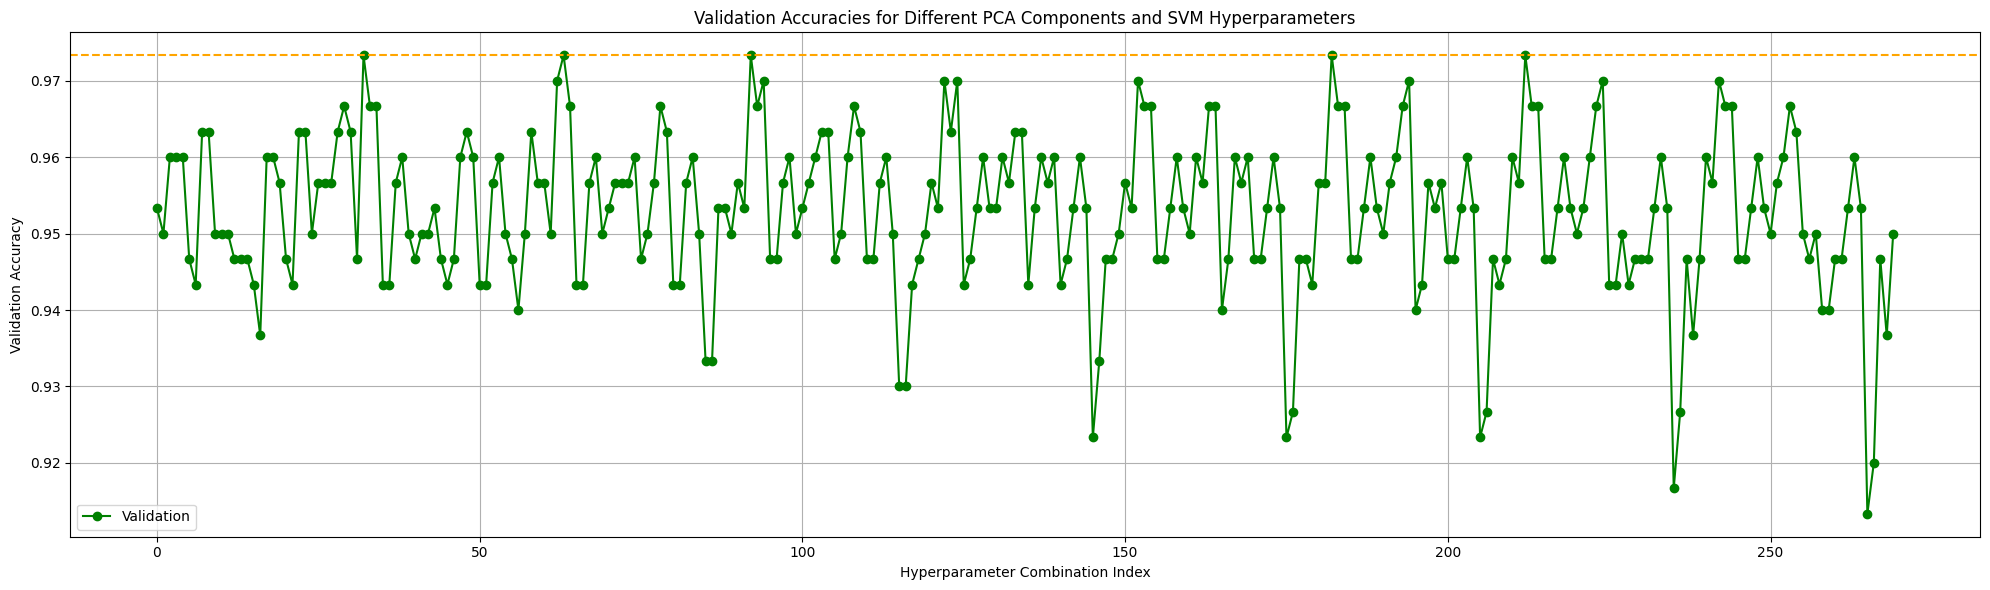

We found the best params {'C': 2, 'gamma': 'scale', 'kernel': 'rbf', 'n_components': 12} with validation accuracy 0.9733.


In [14]:
param_grid = {
    'n_components': range(10, 15),      
    'C': range(1, 10),                  
    'gamma': ['scale', 'auto'],         
    'kernel': ['rbf', 'linear', 'poly']         
}

scaler = MinMaxScaler()
Xtrain_minmax = scaler.fit_transform(X_train)
Xval_minmax = scaler.transform(X_val)

param_comb = list(ParameterGrid(param_grid))

val_metric = []

for params in param_comb:
    pca = PCA(n_components=params['n_components'], random_state=random_seed).fit(Xtrain_minmax)
    
    Xtrain_pca = pca.transform(Xtrain_minmax)
    Xval_pca = pca.transform(Xval_minmax)
    
    clfSVM = SVC(C=params['C'], gamma=params['gamma'], kernel=params['kernel'], random_state=random_seed)
    clfSVM.fit(Xtrain_pca, y_train)
    
    acc = accuracy_score(y_val, clfSVM.predict(Xval_pca))
    val_metric.append(acc)

best_idx = np.argmax(val_metric)
best_params_clfSVM_pca = param_comb[best_idx]
best_accuracy_clfSVM_pca = max(val_metric)

plt.figure(figsize=(20,6))
plt.plot(val_metric, 'go-', label='Validation')
plt.axhline(y=best_accuracy_clfSVM_pca, color='orange', linestyle='--')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation'])
plt.title('Validation Accuracies for Different PCA Components and SVM Hyperparameters')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"We found the best params {best_params_clfSVM_pca} with validation accuracy {best_accuracy_clfSVM_pca:.4f}.")

PCA + GaussianNB

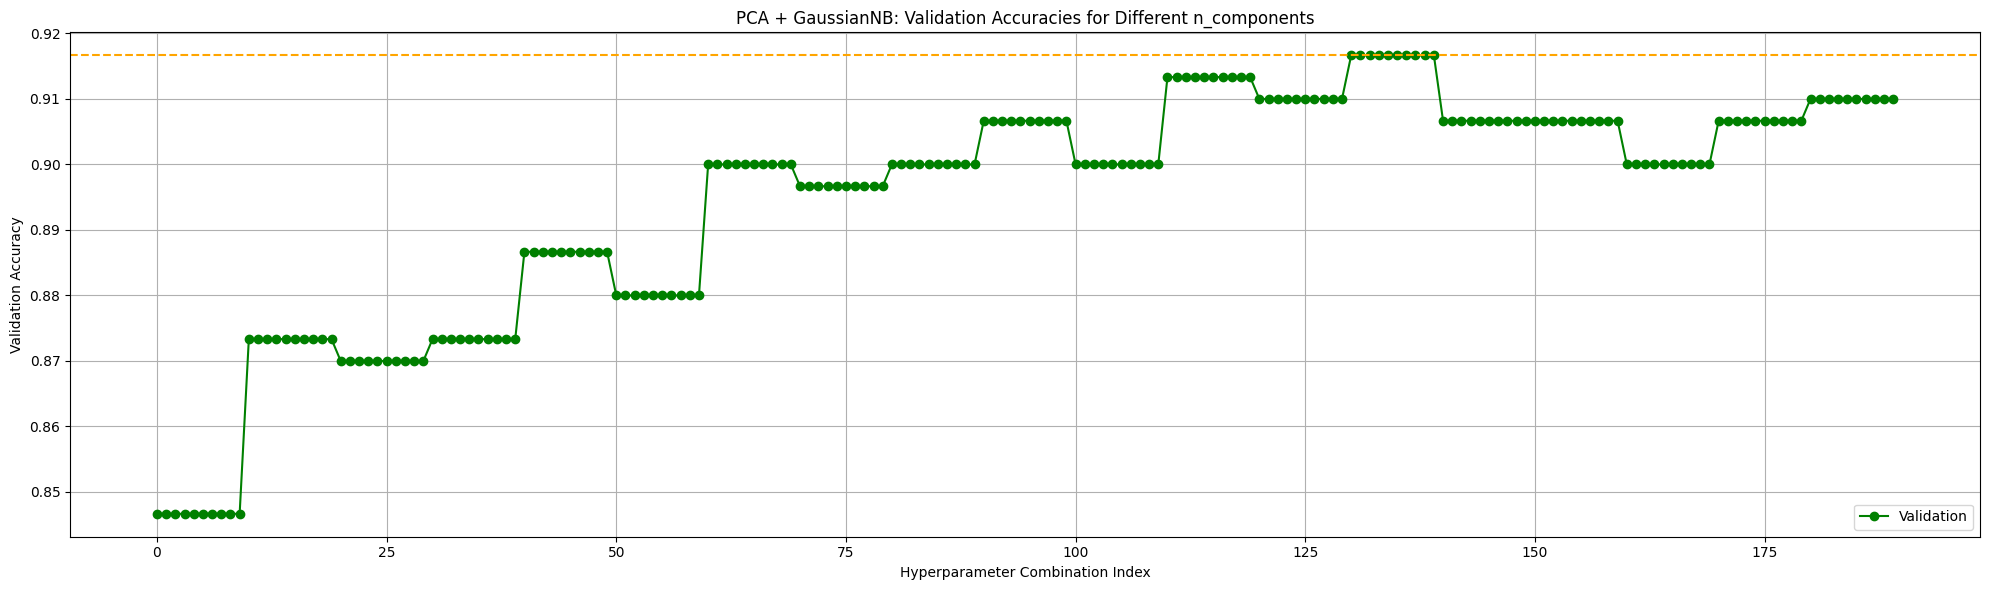

Best n_components for PCA + GaussianNB : 14 with validation accuracy 0.9167


In [152]:
param_grid_gauss = {
    'n_components': range(1, 20),                   
    'var_smoothing': np.arange(1e-9, 1e-7, 1e-8),    
    'normalization': [Binarizer()]  
    
}

param_comb_gauss = list(ParameterGrid(param_grid_gauss))
val_metric_gauss = []

for params in param_comb_gauss:
    pca = PCA(n_components=params['n_components'], random_state=random_seed).fit(Xtrain_minmax)
    Xtrain_pca = pca.transform(Xtrain_minmax)
    Xval_pca = pca.transform(Xval_minmax)
    
    clf_gauss = GaussianNB()
    clf_gauss.fit(Xtrain_pca, y_train)
    acc = accuracy_score(y_val, clf_gauss.predict(Xval_pca))
    val_metric_gauss.append(acc)

best_idx_gauss = np.argmax(val_metric_gauss)
best_acc_gauss = val_metric_gauss[best_idx_gauss]
best_ncomp_gauss = param_comb_gauss[best_idx_gauss]['n_components']

# Plot validation accuracies
plt.figure(figsize=(20,6))
plt.plot(val_metric_gauss, 'go-', label='Validation')
plt.axhline(y=best_acc_gauss, color='orange', linestyle='--')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation'])
plt.title('PCA + GaussianNB: Validation Accuracies for Different n_components')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best n_components for PCA + GaussianNB : {best_ncomp_gauss} with validation accuracy {best_acc_gauss:.4f}")

PCA + BernoulliNB

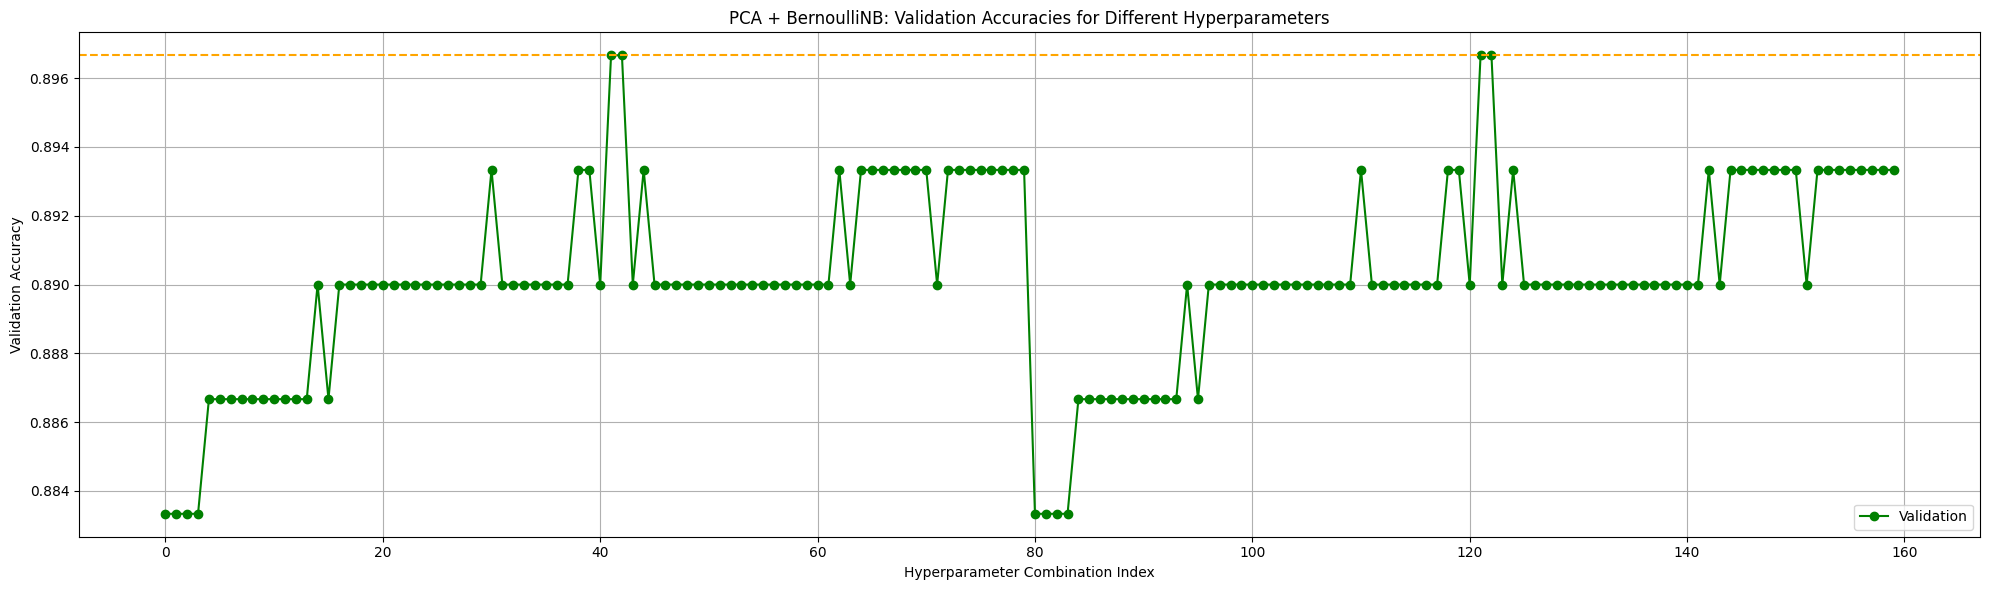

We found the best params for PCA + BernoulliNB: {'alpha': np.float64(0.01), 'binarize': np.float64(0.6), 'n_components': 8, 'normalizer': Binarizer()} with validation accuracy 0.8967


In [153]:
param_grid_bern = {
     'n_components': range(7, 15),
    'alpha': np.arange(0.01, 1, 0.5), 
    'binarize': np.arange(0.1, 1.1, 0.1),  
    'normalizer': [Binarizer()]                  
}

param_comb_bern = list(ParameterGrid(param_grid_bern))
val_metric_bern = []

for params in param_comb_bern:
    normalizer = params['normalizer'].fit(X_train)
    X_train_norm = normalizer.transform(X_train)
    X_val_norm = normalizer.transform(X_val)
    
    pca_model = PCA(n_components=params['n_components'], random_state=random_seed)
    X_train_pca = pca_model.fit_transform(X_train_norm)
    X_val_pca = pca_model.transform(X_val_norm)
    
    clfBern = BernoulliNB(alpha=params['alpha'], binarize=params['binarize'])
    clfBern.fit(X_train_pca, y_train)
    
    acc = accuracy_score(y_val, clfBern.predict(X_val_pca))
    val_metric_bern.append(acc)

best_idx_bern = np.argmax(val_metric_bern)
best_params_bern = param_comb_bern[best_idx_bern]
best_accuracy_bern = val_metric_bern[best_idx_bern]

plt.figure(figsize=(20, 6))
plt.plot(val_metric_bern, 'go-', label='Validation')
plt.axhline(y=best_accuracy_bern, color='orange', linestyle='--')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation'])
plt.title('PCA + BernoulliNB: Validation Accuracies for Different Hyperparameters')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"We found the best params for PCA + BernoulliNB: {best_params_bern} with validation accuracy {best_accuracy_bern:.4f}")

PCA + MultinomialNB

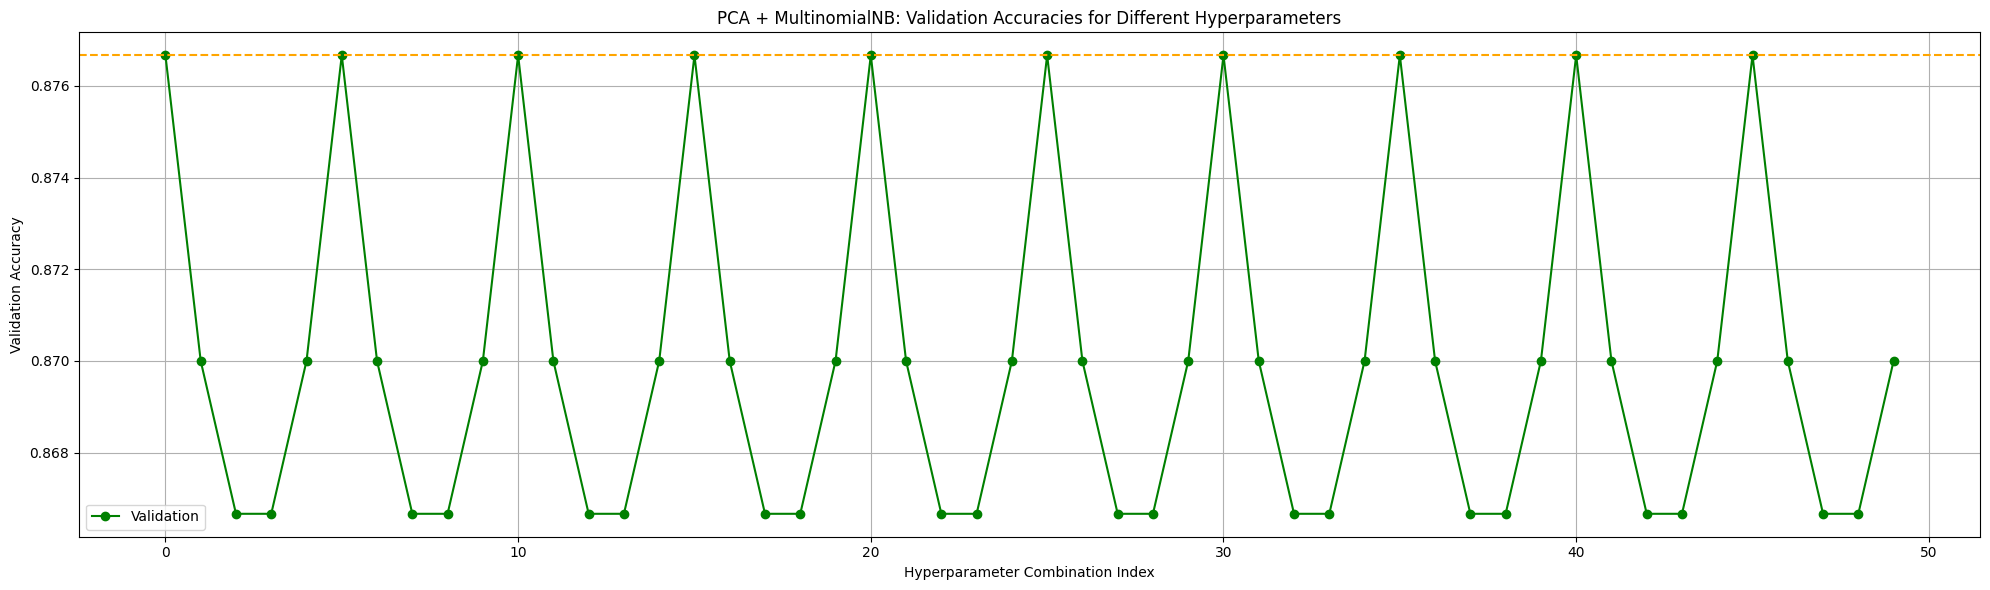

We found the best params {'alpha': np.float64(0.01), 'n_components': 5, 'normalization': Binarizer()} with validation accuracy 0.9567.


In [154]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

param_grid_multi = {
    'n_components': range(5, 10),
    'alpha': np.arange(0.01, 1, 0.1),
    'normalization': [Binarizer()]
}

param_comb_multi = list(ParameterGrid(param_grid_multi))
val_metric_multi = []

for params in param_comb_multi:
    pca = PCA(n_components=params['n_components'], random_state=random_seed).fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)

    min_val = X_train_pca.min()
    if min_val < 0:
        X_train_pca = X_train_pca + abs(min_val)
        X_val_pca = X_val_pca + abs(min_val)
        
    clf_multi = MultinomialNB(alpha=params['alpha'])
    clf_multi.fit(X_train_pca, y_train)
    
    acc = accuracy_score(y_val, clf_multi.predict(X_val_pca))
    val_metric_multi.append(acc)

best_idx_multi = np.argmax(val_metric_multi)
best_acc_multi = val_metric_multi[best_idx_multi]
best_params_multi = param_comb_multi[best_idx_multi]

plt.figure(figsize=(20,6))
plt.plot(val_metric_multi, 'go-', label='Validation')
plt.axhline(y=best_acc_multi, color='orange', linestyle='--')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation'])
plt.title('PCA + MultinomialNB: Validation Accuracies for Different Hyperparameters')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"We found the best params {best_params_multi} with validation accuracy {best_score:.4f}.")

PCA + LDA

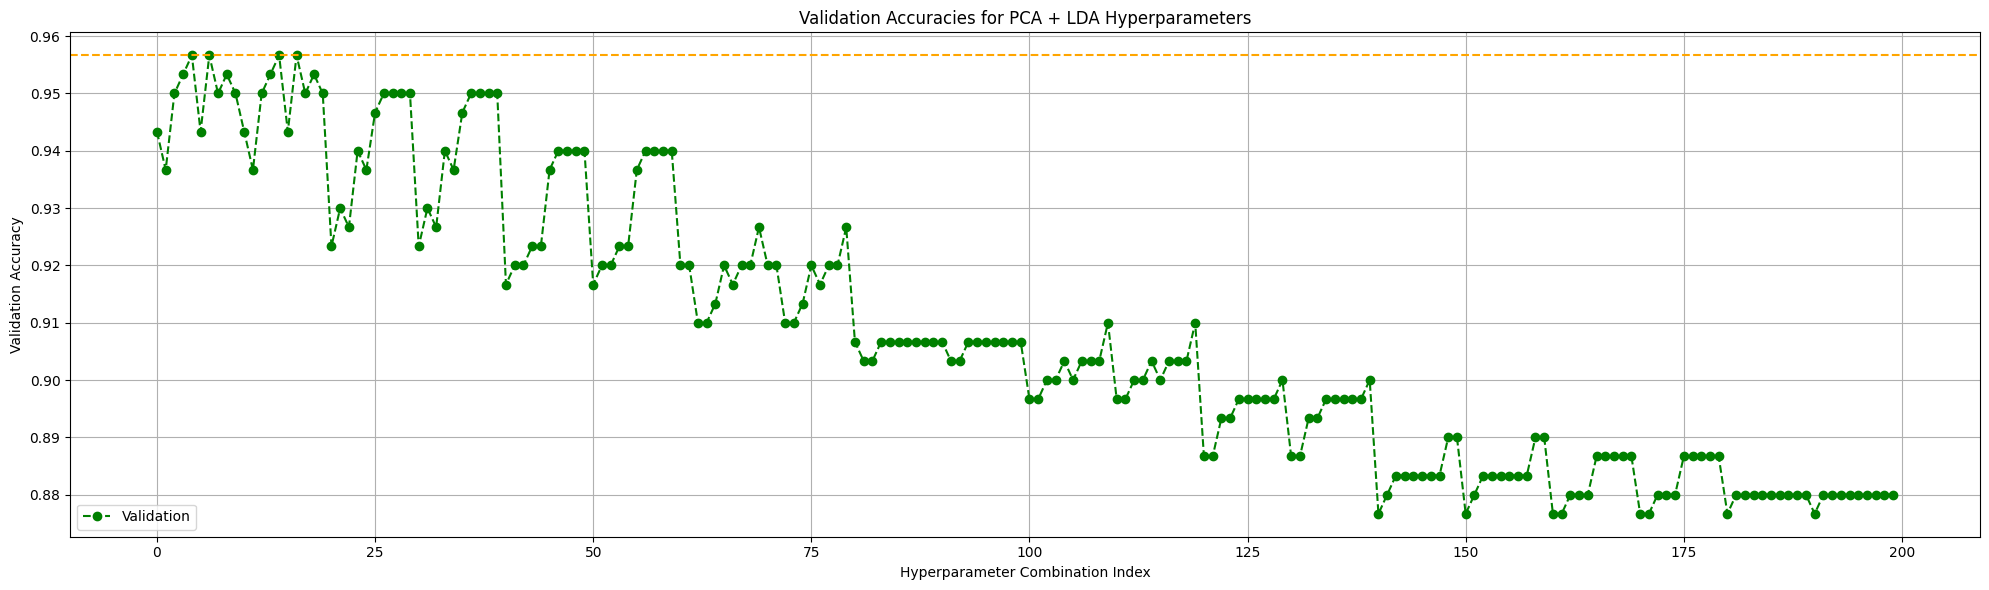

We found the best params {'lda_n_components': 1, 'lda_shrinkage': np.float64(0.01), 'lda_solver': 'lsqr', 'normalizer': MinMaxScaler(), 'pca_n_components': 14} with validation accuracy 0.9567.


In [155]:
param_grid_lda = {
    'pca_n_components': range(10, 20),  
    'lda_solver': ['lsqr', 'eigen'],     
    'lda_shrinkage': np.arange(0.01, 1, 0.1),
    'lda_n_components': range(1, min(len(np.unique(y_train)), X_train.shape[1])),
    'normalizer': [MinMaxScaler()]
}

param_comb_lda = list(ParameterGrid(param_grid_lda))
val_scores = []

for params in param_comb_lda:
    scaler = params['normalizer'].fit(Xtrain_minmax)
    Xtrain_norm = scaler.transform(Xtrain_minmax)
    Xval_norm = scaler.transform(Xval_minmax)
    
    pca = PCA(n_components=params['pca_n_components'], random_state=random_seed).fit(Xtrain_norm)
    Xtrain_pca = pca.transform(Xtrain_norm)
    Xval_pca = pca.transform(Xval_norm)
    
    lda = LinearDiscriminantAnalysis(solver=params['lda_solver'],
                                     shrinkage=params['lda_shrinkage'],
                                     n_components=params['lda_n_components'])
    lda.fit(Xtrain_pca, y_train)
    
    score = accuracy_score(y_val, lda.predict(Xval_pca))
    val_scores.append(score)

best_idx_lda = np.argmax(val_scores)
best_params_lda = param_comb_lda[best_idx_lda]
best_score = val_scores[best_idx_lda]

plt.figure(figsize=(20,6))
plt.plot(val_scores, 'go--', label='Validation')
plt.axhline(y=best_score, color='orange', linestyle='--')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation'])
plt.title('Validation Accuracies for PCA + LDA Hyperparameters')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"We found the best params {best_params_lda} with validation accuracy {best_score:.4f}.")

**Short conclusion:**


Among the PCA-based models, the best validation performance was achieved by PCA + SVM with a 97.33% accuracy, indicating that SVM can effectively utilize the variance captured by PCA. PCA + LDA followed closely with a 95.67% accuracy, demonstrating its strength in preserving class-discriminative information. Meanwhile, PCA combined with MultinomialNB reached 94.33% accuracy, whereas PCA + GaussianNB and PCA + BernoulliNB achieved 91.67% and 89.67% respectively. These results suggest that, for this dataset, non-linear classifiers such as SVM are better suited to the PCA-transformed features compared to naive Bayes variants.

# Locally Linear Embedding(LLE)

LLE + SVM

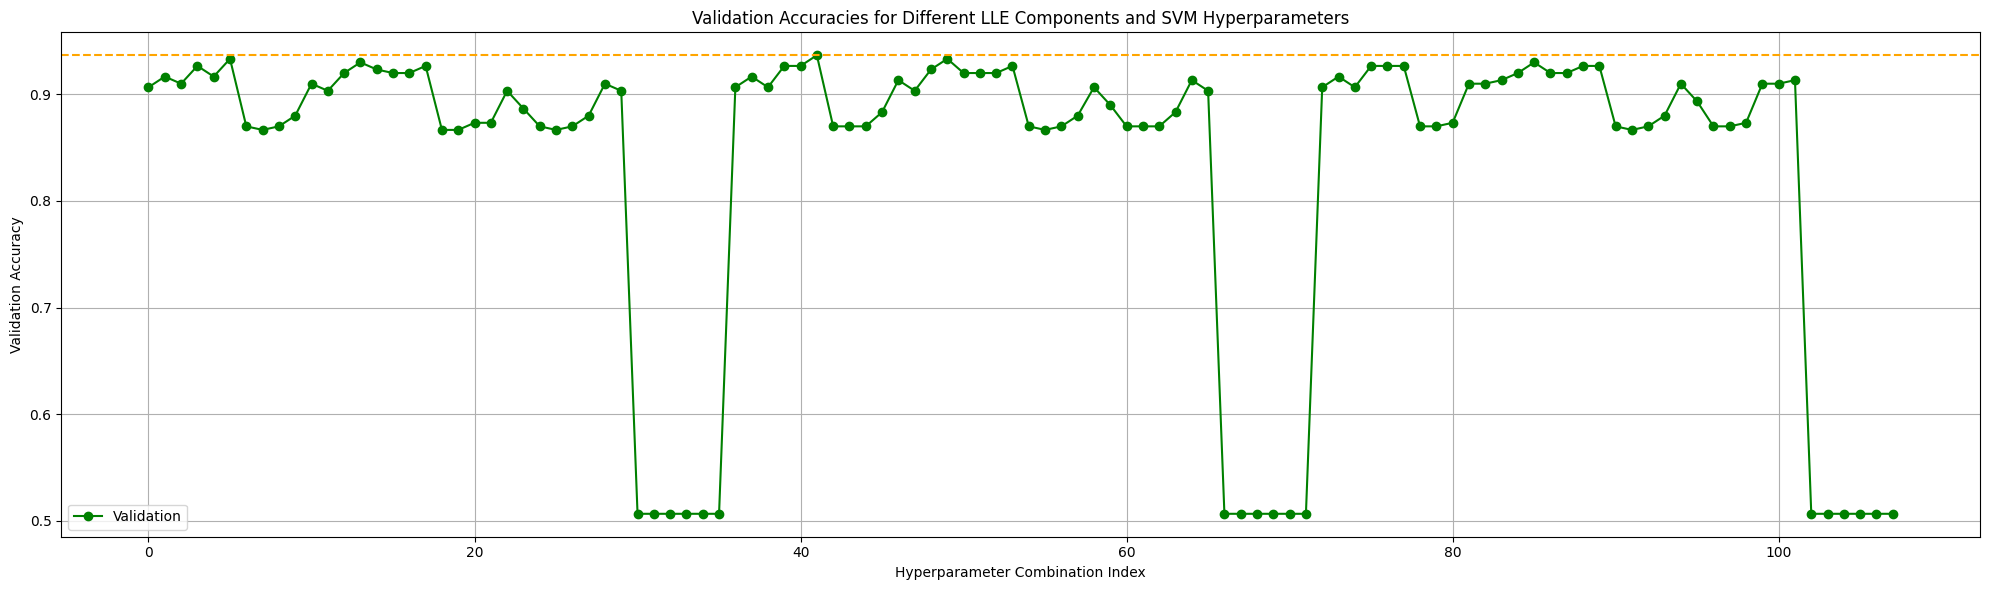

We found the best params for LLE + SVM: {'C': 9, 'gamma': 'scale', 'kernel': 'rbf', 'n_components': 4, 'n_neighbors': 10} with validation accuracy 0.9367.


In [156]:
param_grid_lle = {
    'n_neighbors': range(5, 11),            
    'n_components': [4],               
    'C': [7, 9, 11],                         
    'gamma': ['scale', 'auto'],                
    'kernel': ['rbf', 'linear', 'poly']          
}

param_comb_lle = list(ParameterGrid(param_grid_lle))
val_metric_lle = []

for params in param_comb_lle:
    lle = LocallyLinearEmbedding(n_neighbors=params['n_neighbors'],
                                 n_components=params['n_components'],
                                 random_state=random_seed)
    X_train_lle = lle.fit_transform(X_train)
    X_val_lle = lle.transform(X_val)
    
    clfSVM = SVC(C=params['C'], gamma=params['gamma'], kernel=params['kernel'], random_state=random_seed)
    clfSVM.fit(X_train_lle, y_train)
    
    acc = accuracy_score(y_val, clfSVM.predict(X_val_lle))
    val_metric_lle.append(acc)

best_idx_lle = np.argmax(val_metric_lle)
best_params_clfSVM_lle = param_comb_lle[best_idx_lle]
best_accuracy_lle = val_metric_lle[best_idx_lle]

plt.figure(figsize=(20,6))
plt.plot(val_metric_lle, 'go-', label='Validation')
plt.axhline(y=best_accuracy_lle, color='orange', linestyle='--')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation'])
plt.title('Validation Accuracies for Different LLE Components and SVM Hyperparameters')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"We found the best params for LLE + SVM: {best_params_clfSVM_lle} with validation accuracy {best_accuracy_lle:.4f}.")

LLE + GaussianNB

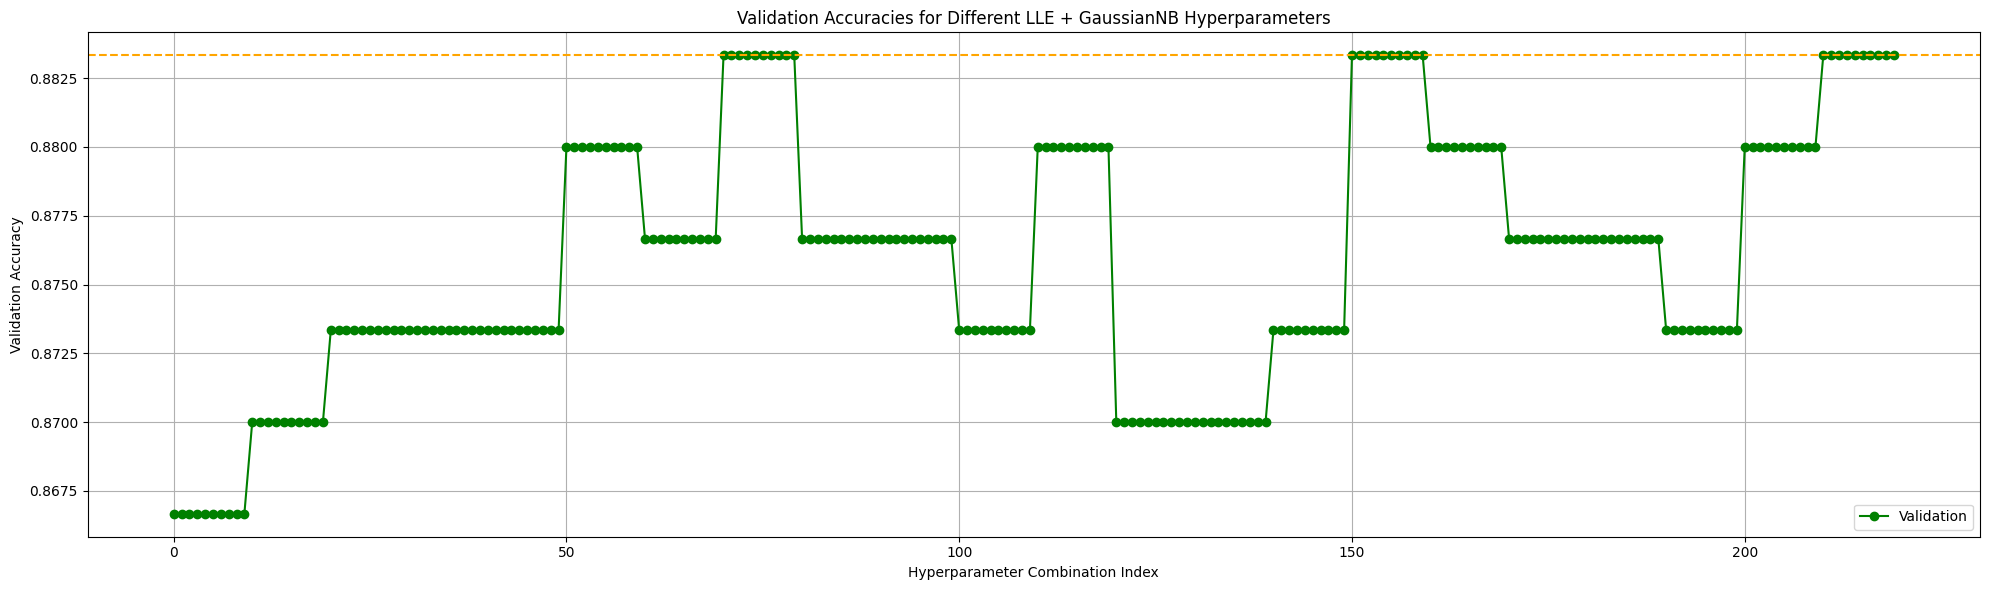

We found the best params for LLE + GaussianNB: {'n_components': 2, 'n_neighbors': 12, 'var_smoothing': np.float64(1e-09)} with validation accuracy 0.8833


In [157]:
param_grid_gauss = {
    'n_neighbors': range(5, 16),             
    'n_components': range(2, 4),             
    'var_smoothing': np.arange(1e-9, 1e-7, 1e-8)
}

param_comb_gauss = list(ParameterGrid(param_grid_gauss))
val_metric_gauss = []

for params in param_comb_gauss:
    lle = LocallyLinearEmbedding(n_neighbors=params['n_neighbors'],
                                 n_components=params['n_components'],
                                 random_state=random_seed)
    X_train_lle = lle.fit_transform(X_train)
    X_val_lle = lle.transform(X_val)
    
    clf_gauss = GaussianNB(var_smoothing=params['var_smoothing'])
    clf_gauss.fit(X_train_lle, y_train)
    
    acc = accuracy_score(y_val, clf_gauss.predict(X_val_lle))
    val_metric_gauss.append(acc)

best_idx_gauss = np.argmax(val_metric_gauss)
best_params_gauss = param_comb_gauss[best_idx_gauss]
best_accuracy_gauss = val_metric_gauss[best_idx_gauss]

plt.figure(figsize=(20,6))
plt.plot(val_metric_gauss, 'go-', label='Validation')
plt.axhline(y=best_accuracy_gauss, color='orange', linestyle='--')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation'])
plt.title('Validation Accuracies for Different LLE + GaussianNB Hyperparameters')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"We found the best params for LLE + GaussianNB: {best_params_gauss} with validation accuracy {best_accuracy_gauss:.4f}")

LLE + BernoulliNB

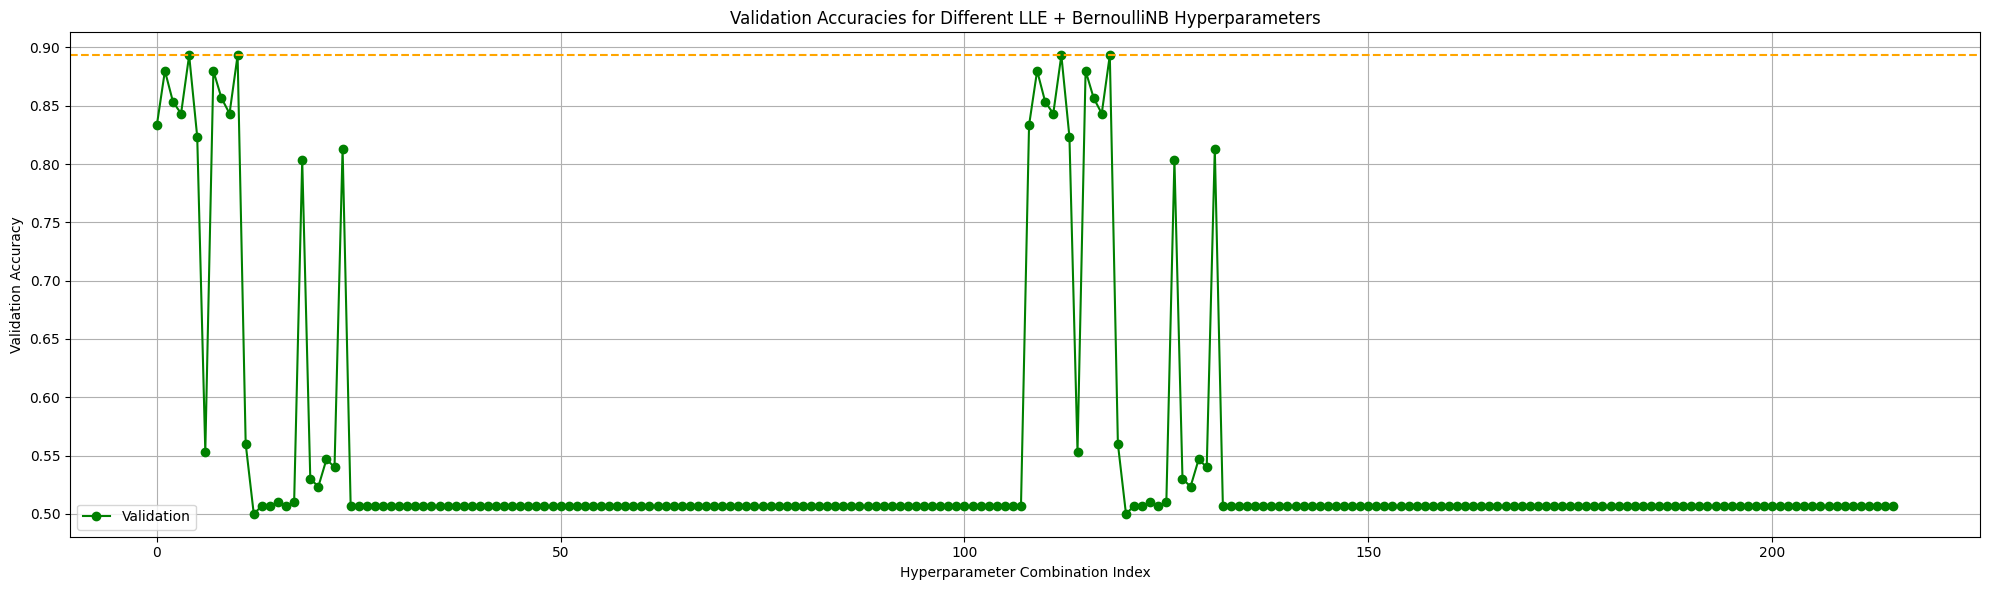

We found the best params for LLE + BernoulliNB: {'alpha': np.float64(0.01), 'binarize': np.float64(0.1), 'n_components': 3, 'n_neighbors': 14} with validation accuracy 0.8933


In [158]:
param_grid_bern = {
    'n_neighbors': range(10, 16),            
    'n_components': range(3, 5),              
    'alpha': np.arange(0.01, 1, 0.5),         
    'binarize': np.arange(0.1, 1, 0.1)      
}

param_comb_bern = list(ParameterGrid(param_grid_bern))
val_metric_bern = []

for params in param_comb_bern:
    lle = LocallyLinearEmbedding(n_neighbors=params['n_neighbors'],
                                 n_components=params['n_components'],
                                 random_state=random_seed)
    X_train_lle = lle.fit_transform(X_train)
    X_val_lle = lle.transform(X_val)
    
    shift_val = X_train_lle.min()
    if shift_val < 0:
        X_train_lle += abs(shift_val)
        X_val_lle += abs(shift_val)
    
    clf_bern = BernoulliNB(alpha=params['alpha'], binarize=params['binarize'])
    clf_bern.fit(X_train_lle, y_train)
    
    acc = accuracy_score(y_val, clf_bern.predict(X_val_lle))
    val_metric_bern.append(acc)

best_idx_bern = np.argmax(val_metric_bern)
best_params_bern = param_comb_bern[best_idx_bern]
best_accuracy_bern = val_metric_bern[best_idx_bern]

plt.figure(figsize=(20,6))
plt.plot(val_metric_bern, 'go-', label='Validation')
plt.axhline(y=best_accuracy_bern, color='orange', linestyle='--')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation'])
plt.title('Validation Accuracies for Different LLE + BernoulliNB Hyperparameters')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"We found the best params for LLE + BernoulliNB: {best_params_bern} with validation accuracy {best_accuracy_bern:.4f}")

LLE + LDA

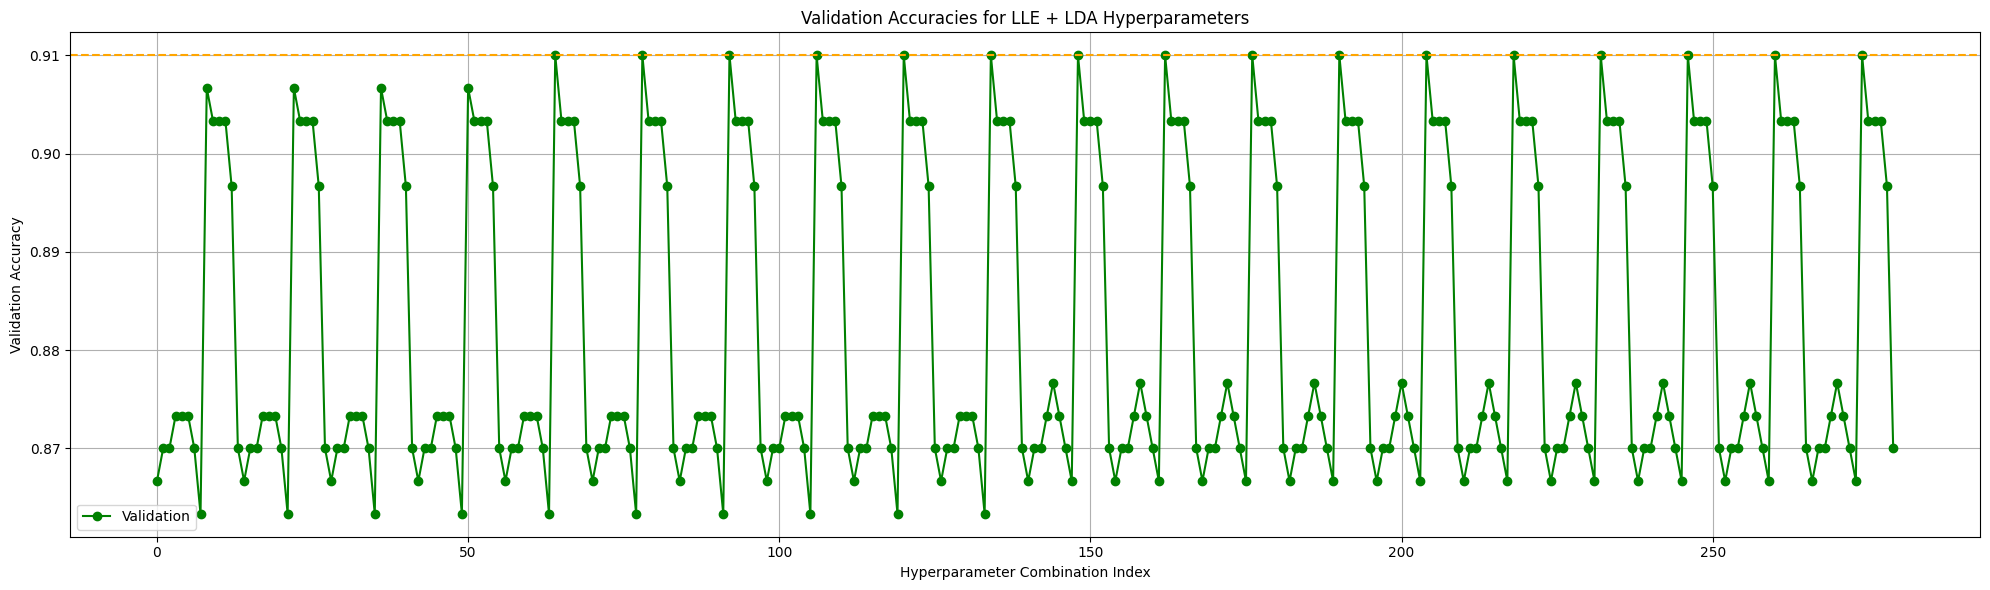

We found the best params for LLE + LDA: {'lda_n_components': 1, 'lda_shrinkage': np.float64(0.21000000000000002), 'lda_solver': 'lsqr', 'lle_n_components': 3, 'lle_n_neighbors': 7} with validation accuracy 0.9100


In [159]:
param_grid_lda = {
    'lle_n_neighbors': [5, 7, 8, 10, 12, 14, 16],
    'lle_n_components': [2, 3],                 
    'lda_solver': ['lsqr', 'eigen'],            
    'lda_shrinkage': np.arange(0.01, 1, 0.1),    
    'lda_n_components': range(1, min(len(np.unique(y_train)), X_train.shape[1]))  
}

param_comb_lda = list(ParameterGrid(param_grid_lda))
val_metric_lda = []

for params in param_comb_lda:
    lle = LocallyLinearEmbedding(n_neighbors=params['lle_n_neighbors'],
                                 n_components=params['lle_n_components'],
                                 random_state=random_seed)
    X_train_lle = lle.fit_transform(X_train)
    X_val_lle = lle.transform(X_val)
    
    lda = LinearDiscriminantAnalysis(solver=params['lda_solver'],
                                     shrinkage=params['lda_shrinkage'],
                                     n_components=params['lda_n_components'])
    lda.fit(X_train_lle, y_train)
    
    acc = accuracy_score(y_val, lda.predict(X_val_lle))
    val_metric_lda.append(acc)

best_idx_lda = np.argmax(val_metric_lda)
best_params_lda = param_comb_lda[best_idx_lda]
best_accuracy_lda = val_metric_lda[best_idx_lda]

plt.figure(figsize=(20,6))
plt.plot(val_metric_lda, 'go-', label='Validation')
plt.axhline(y=best_accuracy_lda, color='orange', linestyle='--')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation'])
plt.title('Validation Accuracies for LLE + LDA Hyperparameters')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"We found the best params for LLE + LDA: {best_params_lda} with validation accuracy {best_accuracy_lda:.4f}")

**Short conclusiion:**

Among the LLE-based pipelines, LLE + SVM achieved the highest validation accuracy (93.67%), outperforming both LLE + LDA (91.00%) and the Naive Bayes variants (LLE + BernoulliNB at 89.33% and LLE + GaussianNB at 88.33%). This indicates that the nonlinear features preserved by LLE are best leveraged by SVM, while the linear approaches (LDA) and NB models, which have stricter distributional assumptions, yield somewhat lower performance.

# Final Model

Although the standalone SVM achieved ~98% accuracy, I chose PCA + SVM with ~97% because PCA reduces noise and complexity, improves generalization, and speeds up computation, making the model more robust overall.

In [33]:
scaler = MinMaxScaler()
Xtrain_minmax = scaler.fit_transform(X_train)
Xval_minmax   = scaler.transform(X_val)
Xtest_minmax  = scaler.transform(X_test)

pca = PCA(n_components=best_params_clfSVM_pca['n_components'], random_state=random_seed)
Xtrain_pca = pca.fit_transform(Xtrain_minmax)
Xval_pca   = pca.transform(Xval_minmax)
Xtest_pca  = pca.transform(Xtest_minmax)

final_model = SVC(C=best_params_clfSVM_pca['C'], 
                  gamma=best_params_clfSVM_pca['gamma'], 
                  kernel=best_params_clfSVM_pca['kernel'], 
                  random_state=random_seed)
final_model.fit(Xtrain_pca, y_train)

val_accuracy  = accuracy_score(y_val, final_model.predict(Xval_pca))
test_accuracy = accuracy_score(y_test, final_model.predict(Xtest_pca))

print("Validation Accuracy: {0:.4f}".format(val_accuracy))
print("Test Accuracy: {0:.4f}".format(test_accuracy))

Validation Accuracy: 0.9733
Test Accuracy: 0.9333


<Figure size 800x600 with 0 Axes>

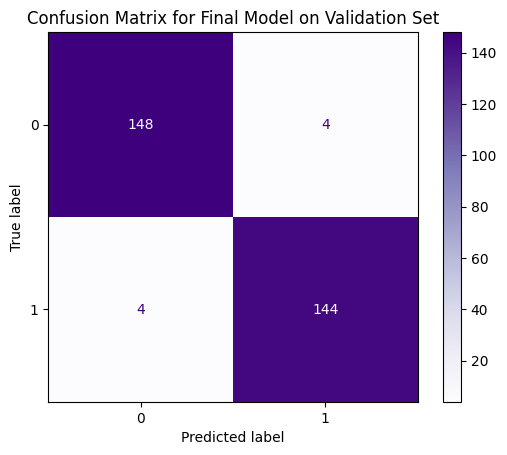

In [46]:
y_val_pred = final_model.predict(Xval_pca)

cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(8,6))
disp.plot(cmap='Purples')
plt.title("Confusion Matrix for Final Model on Validation Set")
plt.show()

The confusion matrix shows that the model is performing very well, with only a few misclassifications in both classes. The high diagonal values indicate high accuracy, and the balanced errors suggest that the model is not biased toward any particular class. This demonstrates strong classification performance overall.

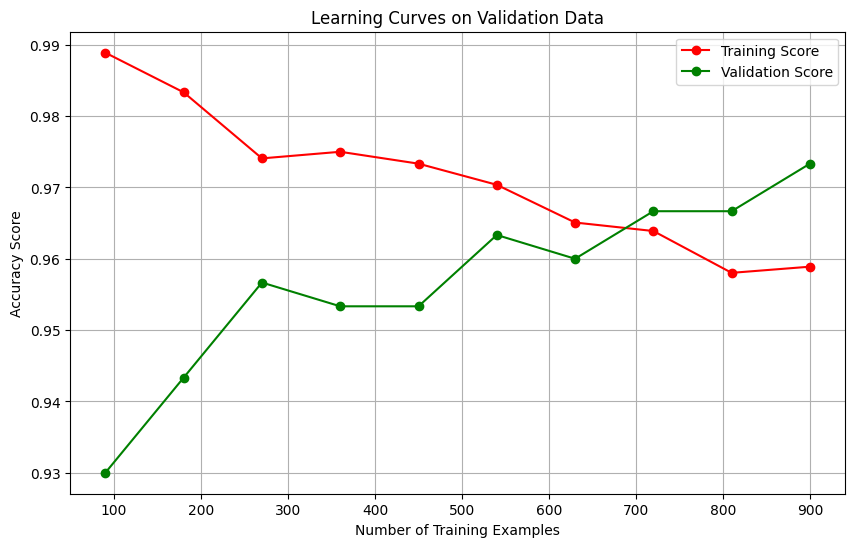

In [41]:
fractions = np.linspace(0.1, 1.0, 10)
train_scores = []
val_scores = []
n_train_total = len(Xtrain_pca)

for frac in fractions:
    subset_size = int(frac * n_train_total)
    Xtrain_subset = Xtrain_pca[:subset_size]
    ytrain_subset = y_train[:subset_size]
    
    # Clone to avoid data leakage 
    model = clone(final_model)
    model.fit(Xtrain_subset, ytrain_subset)
    
    train_pred = model.predict(Xtrain_subset)
    val_pred   = model.predict(Xval_pca)
    
    train_scores.append(accuracy_score(ytrain_subset, train_pred))
    val_scores.append(accuracy_score(y_val, val_pred))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fractions * n_train_total, train_scores, 'o-', color='r', label="Training Score")
plt.plot(fractions * n_train_total, val_scores, 'o-', color='g', label="Validation Score")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy Score")
plt.title("Learning Curves on Validation Data")
plt.legend(loc="best")
plt.grid(True)
plt.show()

This learning curve shows that the model starts with very high training accuracy and gradually decreases as more data is used, while the validation accuracy initially dips but then steadily increases. The gap between the two curves narrows over time, indicating the model generalizes well and benefits from additional training data, ultimately stabilizing at a high accuracy level on the validation set.

In [47]:
df_evaluate = pd.read_csv('evaluate.csv')  

In [48]:
display(df_evaluate.describe())
display(df_evaluate.info())

,ID,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,1500.000000,1500.0,1500.0,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000
mean,749.500000,0.0,0.0,0.003333,0.016667,0.138000,0.207333,0.476667,1.285333,3.320667,...,46.502667,26.196667,12.407333,24.018667,36.210667,28.64800,11.009333,1.432667,0.300000,0.050000
std,433.157015,0.0,0.0,0.068254,0.213899,1.896669,2.292273,4.784633,10.885598,17.590645,...,60.427932,48.003912,33.540434,51.288972,65.614026,56.72936,31.955125,11.608703,5.241531,1.936492
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,374.750000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,749.500000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1124.250000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,85.000000,34.000000,0.000000,4.000000,48.000000,17.00000,0.000000,0.000000,0.000000,0.000000
max,1499.000000,0.0,0.0,2.000000,6.000000,40.000000,48.000000,141.000000,211.000000,227.000000,...,241.000000,240.000000,246.000000,230.000000,245.000000,246.00000,211.000000,173.000000,133.000000,75.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 785 entries, ID to pixel784
dtypes: int64(785)
memory usage: 9.0 MB


None

In [49]:
df_evaluate.isnull().sum()

ID          0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [50]:
df_evaluate.duplicated().sum()

np.int64(0)

In [51]:
ID = df_evaluate['ID']
df_evaluate = df_evaluate.drop(['ID'], axis=1)

X_eval_minmax = scaler.transform(df_evaluate.values)
X_eval_pca = pca.transform(X_eval_minmax)

eval_predictions = final_model.predict(X_eval_pca)

results_df = pd.DataFrame({
    'ID': ID,
    'label': eval_predictions
})

In [52]:
results_df.to_csv('results.csv', index=False)
print("Results saved to results.csv")

Results saved to results.csv
